# Предсказание оценки стабильной части средств на счетах физических лиц

## Постановка задачи

Все средства на расчетных счетах клиенты могут в любой момент забрать из Банка, а в ожидании этого Банк не может их использовать в долгосрочном / среднесрочном плане (например, для выдачи кредитов). Получается, что в такой ситуации Банк ничего не зарабатывает, но платит клиентам проценты по средствам на их счетах, пусть и не высокие, но в масштабах бизнеса Банка эти убытки могут быть значительны.

Но в реальности поведение клиентов другое, оно зависит от многих факторов (поведенческих, макроэкономических, действий конкурентов и т.д.). Клиенты не забирают сразу все свои средства с расчетных счетов, а какое-то время их там хранят, поэтому суммарно по всем клиентам на их расчетных счетах всегда находится какой-то объем средств, который хоть и меняется со временем, но может быть расценен Банком как стабильный и использован для выдачи кредитов (а Банк на этом зарабатывает).

Умение точно прогнозировать объем и динамику стабильного остатка средств на расчетных счетах позволяет Банку зарабатывать на кредитовании, но при этом держать в приемлемых рамках риск того, что клиенты могут в любой момент потребовать эти средства назад – это называется "управление риском ликвидности". Для этого строится ML модель прогнозирования стабильного остатка средств на расчетных счетах клиентов, связанная с моделями прогноза рынков, макроэкономики и поведения клиентов.

В рассматриваемом датасете представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов» (такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный объем расчетных счетов.

Необходимо построить модель, которая оценивает объем стабильной части средств на дату:

model_forecast(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

Нужно одновременно минимизировать величины:
- максимальный объем пробития стабильный части на валидационной выборке
- фактическая стабильная часть – модельная стабильная часть

Этими величинами определяется качество модели.

Итак, будем минимизировать следующие метрики:

- ошибку sMAPE
- максимальный объем пробития стабильной части на валидационной выборке (по заданию)

## Подключаемые библиотеки

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install sktime[all_extras]
#!pip install -U kaleido
#!pip install holidays
#!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.0/745.0 kB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 18.1 MB/s eta 0:00:00
     ━

In [4]:
from google.colab.patches import cv2_imshow
import cv2

In [5]:
# вспомогательные
import numpy as np
from datetime import datetime
import pandas as pd

# для отрисовки
import plotly.graph_objects as go
# import matplotlib.pyplot as plt

# для предобработки рядов
# from statsmodels.tsa.stattools import adfuller, kpss
from sktime.param_est.stationarity import StationarityADF, StationarityKPSS
from sktime.param_est.seasonality import SeasonalityPeriodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# прогноз и модели временных рядов
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster # , NaiveVariance
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# классические модели регрессии
import holidays
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool

## Загрузка данных

In [6]:
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')
data = pd.read_csv('data/ВС DS Сбер data.csv', sep=';', index_col='REPORTDATE', parse_dates=['REPORTDATE'], \
                                                                                   date_parser=dateparse) \
                                                                                   .asfreq('D')
#data['REPORTDATE'] = pd.to_datetime(data['REPORTDATE'], format="%d.%m.%Y")
#data.set_index('REPORTDATE', inplace=True)
print(data.shape)
data.head(10)

(2111, 1)


,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
2014-01-04,3417092149
2014-01-05,3417092149
2014-01-06,3320846785
2014-01-07,3320846785


## Предобработка данных и их основные статистики

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


Проверка даты на монотонность и на повторы

In [8]:
data.index.is_monotonic

True

In [9]:
data.index.duplicated().any()

False

Статистики целевого значения

In [10]:
data.describe()

,VALUE
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


**На этапе загрузки и предобработки:**
- Загружен ряд и изменен формат даты
- Проверена монотонность и отсутсвие повторов
- Отображены основные статистики данных

## Визуализация ряда и его основные характеристики

In [17]:
def plotly_series(*series, labels=None, title='', yaxis_title='Значение (млрд руб)', dtick='M4', ci=None, conf=0.9, img=False, plot=True):
    fig = go.Figure()

    if labels is not None:
        if len(series) != len(labels):
            raise ValueError(
                """There must be one label for each time series,
                but found inconsistent numbers of series and
                labels."""
            )
        legend = True
    else:
        labels = ["" for _ in series]
        legend = False

    for s in zip(series, labels):
        fig.add_trace(go.Scatter(x=s[0].index, y=s[0].values, mode='lines', name = s[1]))

    if ci is not None:
        x_values = ci.index
        fig.add_trace(go.Scatter(x=np.concatenate([x_values, x_values[::-1]]),
                         y=np.concatenate([ci['VALUE', conf,'upper'].values, ci['VALUE', conf, 'lower'].values[::-1]]),
                         fill='toself',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name='Confidence Interval'))

    fig.update_layout(
        title=title,
        yaxis_title=yaxis_title,
        title_x=0.5,
        title_y=0.9,
        xaxis=dict(dtick=dtick),
        legend= dict(orientation='v', x=1.0, y=0.9) if legend else None
    )

    if img:
        fig.write_image("plot.png")
        cv2_imshow(cv2.imread('plot.png', cv2.IMREAD_UNCHANGED))
    if plot:
        fig.show()

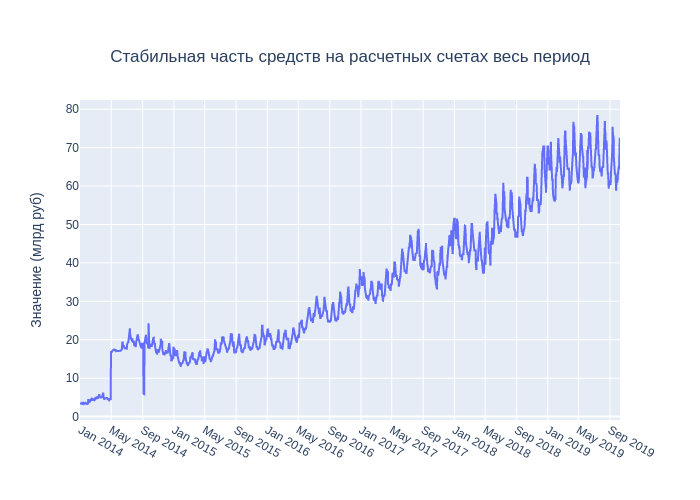

In [18]:
y = data['VALUE'] / 10**9
plotly_series(y, title='Стабильная часть средств на расчетных счетах весь период')

Для того, чтобы рассмотреть по-лучше динамику ряда, визуализируем ряд с начала 2014 по конец 2015, с начала 2016 по конец 2017, а также с начала 2018 по октябрь 2019

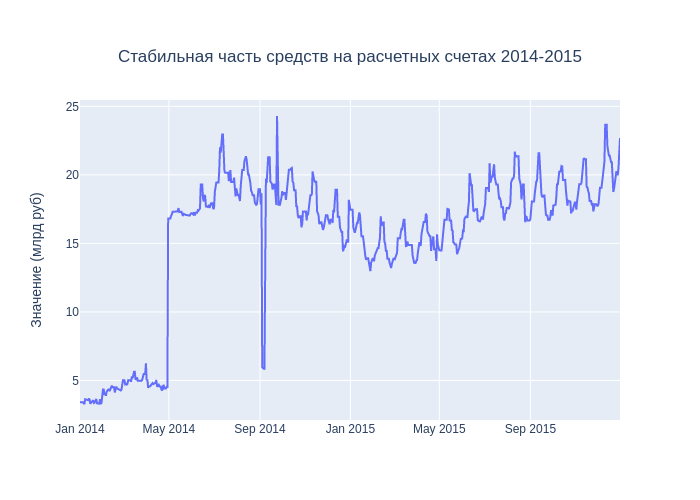

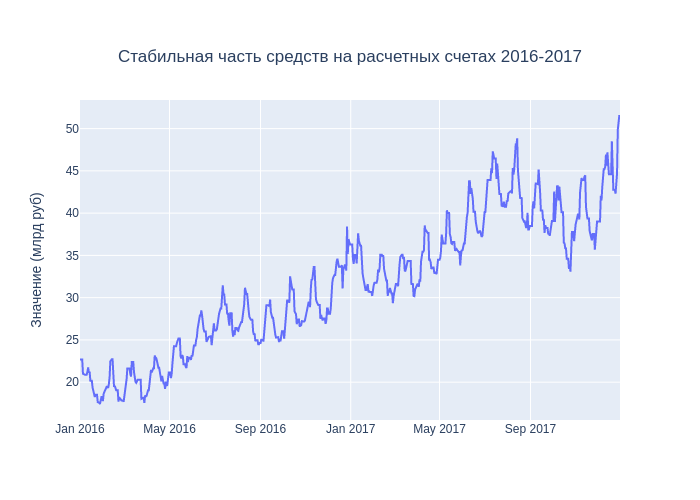

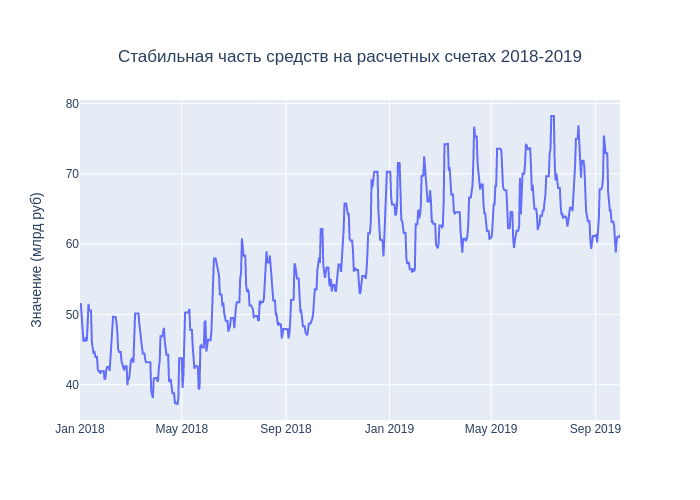

In [19]:
plotly_series(y['2014-01-01':'2015-12-31'], title='Стабильная часть средств на расчетных счетах 2014-2015')
plotly_series(y['2016-01-01':'2017-12-31'], title='Стабильная часть средств на расчетных счетах 2016-2017')
plotly_series(y['2018-01-01':'2019-09-30'], title='Стабильная часть средств на расчетных счетах 2018-2019')

Можно заметить, что до первого октября 2014 часто наблюдались аномалии, вызванные различными экзогенными факторами, которые мы не будем учитывать. Будем рассматривать наш ряд с `01.10.2014`.

In [20]:
y = y['2014-10-01':]

Визуально можно определить нестационарность рассматриваемого ряда (есть как тренд, так и сезонность).

Подтвердим наше предположение с помощью тестов на стационарность. Параметр `ct - constant and trend` указывает на то, какой спецификацией теста мы пользуемся. В данном случае мы видим, что ряд колеблется вокруг тренда, а если убрать его, то он будет колебаться вокруг ненулевого среднего.

In [ ]:
adf = StationarityADF(regression='ct')
adf.fit(y)
adf.get_fitted_params()

{'pvalue': 0.13132243893663254,
 'stationary': False,
 'test_statistic': -3.002718868484376,
 'used_lag': 25}

Нулевая гипотеза расширенного теста Дики-Фуллера о том, что ряд не стационарен, не отвергается из-за `p-value` (который больше чем дефолтный порог `p_threshold=0.05`)

In [ ]:
kpss = StationarityKPSS(regression='ct')
kpss.fit(y)
kpss.get_fitted_params()

/usr/local/lib/python3.10/dist-packages/sktime/param_est/stationarity/_statsmodels.py:255: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




{'lags': 26,
 'pvalue': 0.01,
 'stationary': False,
 'test_statistic': 0.9380379710762636}

Для KPSS-теста мы видим обратную картину: `p-value < p_threshold` нулевая гипотеза о стационарности отвергается в пользу гипотезы о нестационарности.

Таким образом, ряд действительно нестационарен. Но какой период у сезонности?

Для поиска периодичности воспользуемся периодограммой

In [ ]:
sp_est = SeasonalityPeriodogram()
sp_est.fit(y)
sp_est.get_fitted_params()

{'sp': 30, 'sp_significant': [30, 512, 31, 171, 205, 341, 146]}

Видим наличие месячной периодичности.

Теперь мы можем декомпозировать наш ряд на сезонность, тренд и остатки (белый шум)

In [21]:
decompose_res = seasonal_decompose(y, period=30)

In [22]:
observed, seasonal, trend, resid = decompose_res.observed, decompose_res.seasonal, decompose_res.trend, decompose_res.resid

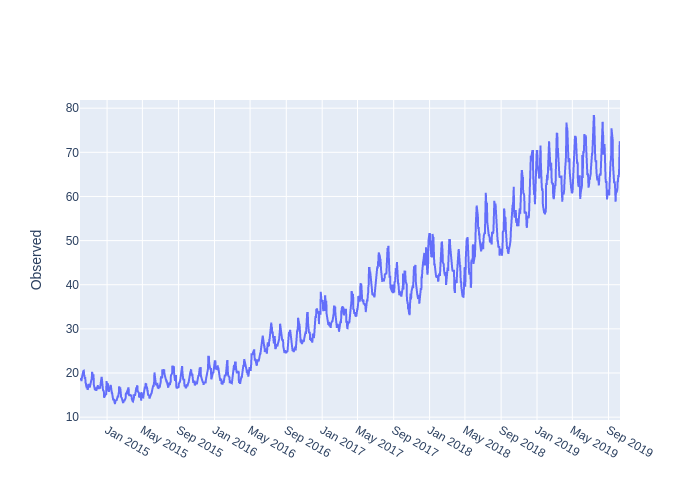

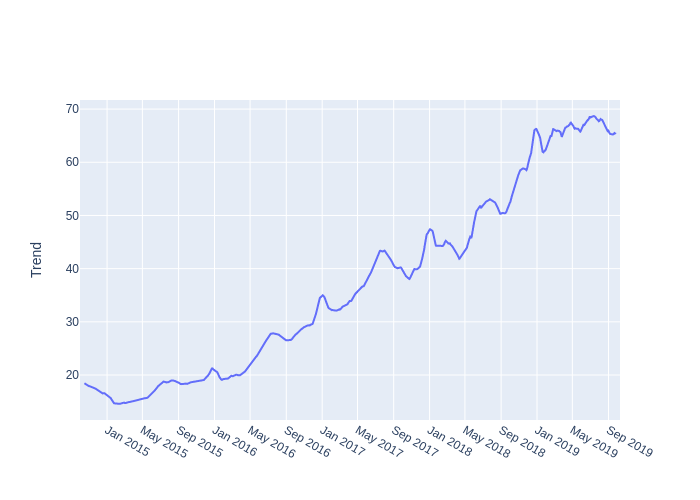

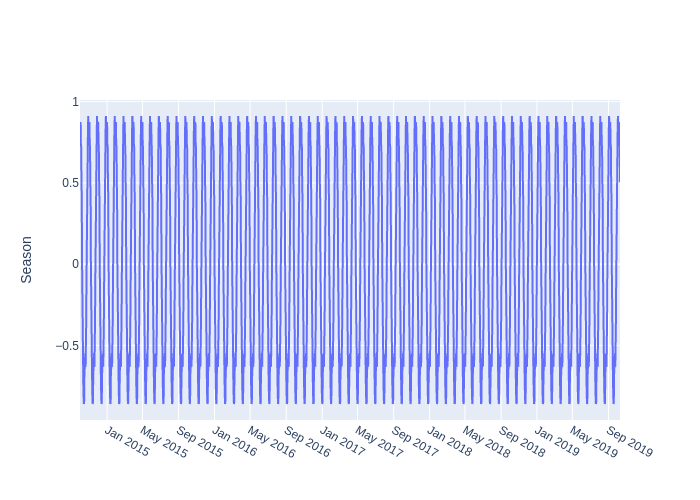

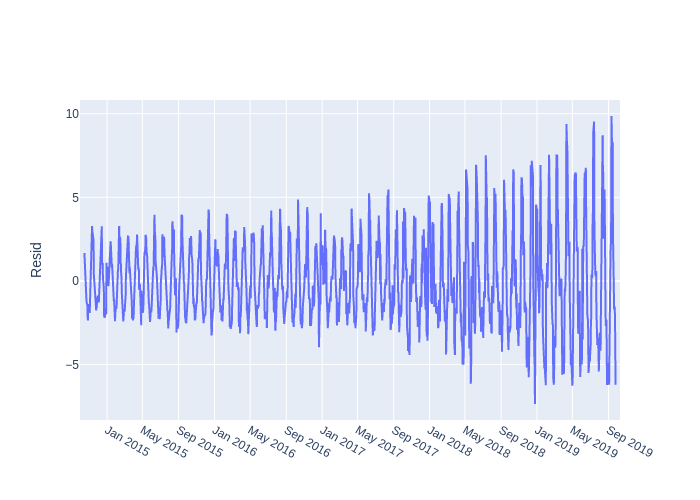

In [23]:
plotly_series(observed, yaxis_title='Observed')
plotly_series(trend, yaxis_title='Trend')
plotly_series(seasonal, yaxis_title='Season')
plotly_series(resid, yaxis_title='Resid')

Для лучшей визуальности - покажем лишь часть из временного интервала

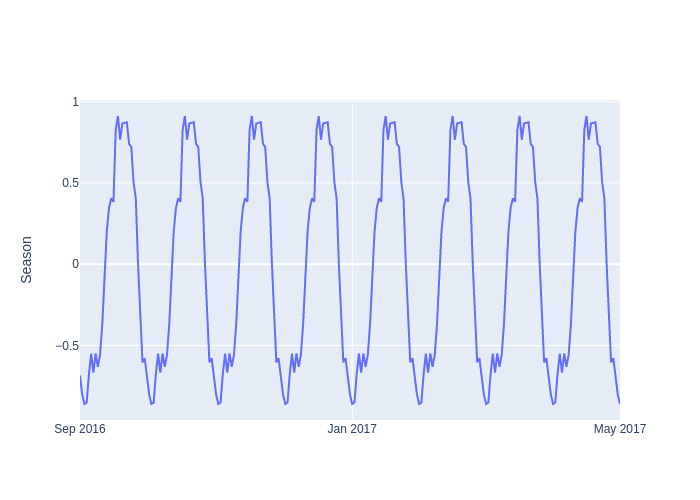

In [24]:
plotly_series(seasonal['2016-09-01':'2017-05-01'], yaxis_title='Season')

Убедимся, что остатки являются шумом и стационарны

In [ ]:
adf_resid = StationarityADF(regression='c')
adf_resid.fit(resid.dropna())
adf_resid.get_fitted_params()

{'pvalue': 0.0,
 'stationary': True,
 'test_statistic': -19.073691965099016,
 'used_lag': 23}

**На этом этапе мы смогли:**
- Провизуализировать ряд, избавиться от аномалий, определить его нестационарность
- Проверить гипотезу о нестационарности с помощью KPSS и ADF
- Определить с помощью периодограммы его периодичность
- Разложить ряд на три составляющие: тренд, сезонность и шум
- Узнать структуру периода

Можно переходить к моделированию

## Модели временных рядов

Определим функции для расчета метрик

In [25]:
# def sMAPE(y, y_pred):
#     if not all([isinstance(y, np.ndarray),
#                 isinstance(y_pred, np.ndarray)]):
#         y, y_pred = np.array(y), np.array(y_pred)

#     return round(
#         np.mean(
#             np.abs(y_pred - y) /
#             ((np.abs(y) + np.abs(y_pred))/2)
#         )*100, 5
#     )

def sMAPE(y, y_pred):
    smape = MeanAbsolutePercentageError(symmetric=True)
    return round(smape(y, y_pred) * 100, 5)


def max_breakdown(y, y_pred):
    breakdown = round(y_pred.min() - y.min(), 5)
    return 0 if breakdown < 0 else breakdown

Этими величинами будет определяться качество выбранных моделей.

Формула `sMAPE` выглядит следующим образом:
$$ sMAPE = \frac{2}{n} \sum\limits_{i=1}^n \frac{|y_i - \hat{y_i}|}{|y_i| + |\hat{y_i}|} \times 100 $$

Она хороша тем, что равномерно учитывает и недооценку, и переоценку прогнозов.

"Пробитие" происходит, когда прогнозная оценка превышает истинное значение.

Разделим выборку на обучающую и тестовую. За тест возьмем последние 365 дней

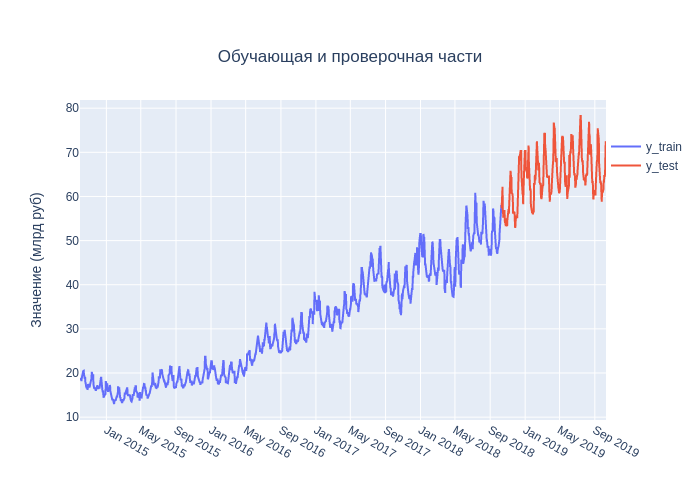

1471 365


In [26]:
y_train, y_test = temporal_train_test_split(y, test_size=365)
plotly_series(y_train, y_test, labels=["y_train", "y_test"], title='Обучающая и проверочная части')
print(y_train.shape[0], y_test.shape[0])

Чтобы прогнозы корректно индексировались, заведём отдельную переменную с индексами-датами

In [27]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2018-10-11', '2018-10-12', '2018-10-13', '2018-10-14',
               '2018-10-15', '2018-10-16', '2018-10-17', '2018-10-18',
               '2018-10-19', '2018-10-20',
               ...
               '2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
               '2019-10-05', '2019-10-06', '2019-10-07', '2019-10-08',
               '2019-10-09', '2019-10-10'],
              dtype='datetime64[ns]', name='REPORTDATE', length=365, freq='D', is_relative=False)

### Наивная сезонная модель sNAIVE (baseline)

Нам нужно для оценки какой-нибудь сложной модели иметь некоторый baseline для сравнения. Хорошей моделью для этой цели может послужить `sNAIVE` (сезонный наивный метод прогнозирования), в таком случае прогноз равен значению, которое принимает показатель в такой же день предыдущего периода. Но такой прогноз не учитывает влияние тренда, поэтому этот тренд мы обучим отдельно и учтем в прогнозе наивной модели. Мы знаем, что тренд имеет не совсем линейную структуру, поэтому будем использовать квадратичный тренд.

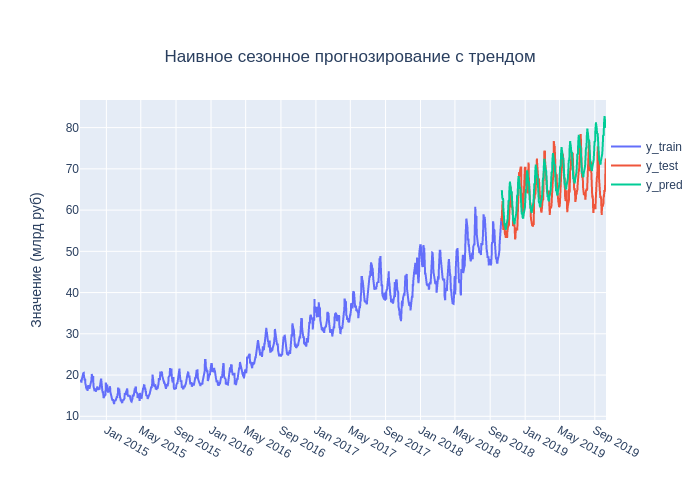

In [28]:
nf_last = NaiveForecaster(strategy="last", sp=30)
nf_last.fit(y_train)

y_last = nf_last.predict(fh)

nf_trend = PolynomialTrendForecaster(degree=2)
nf_trend.fit(y_train)

y_trend = nf_trend.predict(fh)

nf_y_pred = y_trend.add(y_last.sub(min(y_last)))

plotly_series(y_train, y_test, nf_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Наивное сезонное прогнозирование с трендом')

Взглянем ближе

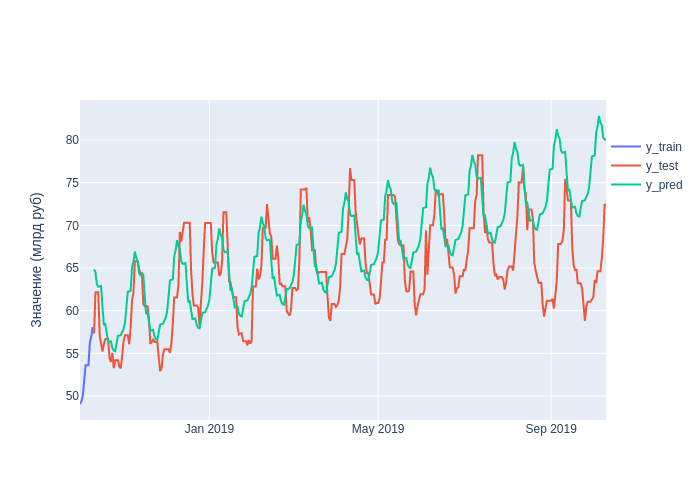

In [29]:
plotly_series(y_train['2018-10-01':], y_test, nf_y_pred, labels=["y_train", "y_test", "y_pred"])

Теперь рассчитаем наши критерии качества для этой элементарной модели

In [30]:
results = {} # в этот словарь будем сохранять все результаты моделирования
results["Naive"] = {"sMAPE": sMAPE(y_test, nf_y_pred), "break": max_breakdown(y_test, nf_y_pred)}
print(f"Naive sMAPE - {results['Naive']['sMAPE']}")
print(f"Naive breakdown - {results['Naive']['break']}")

Naive sMAPE - 6.92742
Naive breakdown - 2.34531


Именно с таким прогнозом мы и будем ‘‘бороться’’ с помощью более продвинутых методов.

### SARIMA

Одной из таких моделей является $SARIMA(p,d,q)-(P,D,Q)[sp]$-модель:

* $S$ $-$ сезонная модель с периодом $sp$
* $AR(p)$ $-$ модель авторегрессии, которая предсказывает текущее (будущее) значение временного ряда на основе $p$ его предыдущих значений, $SAR(P)$ $-$ сезонная авторегрессия, которая дополняет прогноз еще и $P$ предыдущими значениями прошлого периода
* $MA(q)$ $-$ модель скользящего среднего, которая предсказывает текущее (будущее) значение временного ряда на основе $q$ ошибок предыдущих прогнозов, $SMA(Q)$ $-$ сезонное скользящее среднее, которое дополняет прогноз еще и $Q$ предыдущих ошибок прошлого периода
* $ARMA(p,q)$ $-$ модель авторегрессии со скользящим средним, $SARMA(p,q)-(P, Q)[sp]$ $-$ сезонная модель авторегрессии со скользящим средним
* $SARIMA(p,d,q)-(P,D,Q)[sp]$ $-$ сезонная модель авторегрессии со скользящим средним, где
 * $d$ $-$ порядок разности ряда, для того, чтобы он стал стационарным (порядок интегрирования)
 * $D$ $-$ порядок сезонной разности (порядок сезонного интегрирования)

Как работает модель:
1. ‘‘Остационаривание’’
    * Так как ряд нестационарен, берем первую, вторую и т.д. разность, пока он не станет стационарным
    * KPSS-тест для подбора $d$
    * SEAS-тест для подбора $D$

2. Перебор гиперпараметров $p,q, P, Q$
    * Подбор $p,q, P, Q$ через минимизацию информационного критерия

In [ ]:
# arima_auto = StatsForecastAutoARIMA(
#     max_p=3, max_q=3,

#     seasonal=True, sp=30,
#     max_P=3, max_Q=3,
#     max_order=12, # p + P + q + Q

#     max_D=2, max_d=2,
#     test='kpss', # по умолчанию
#     seasonal_test='seas',  # по умолчанию

#     trace=True,
#     stepwise=False, # полный перебор
#     method='CSS', # conditional-sum-of-squares
#     information_criterion='bic', # информационный критерий
# )
# arima_auto.fit(y_train)

Fitting models using approximations to speed things up
Best model: ARIMA(3,0,1)(1,1,0)[30] with drift        




StatsForecastAutoARIMA(information_criterion='bic', max_D=2, max_P=3, max_Q=3,
                       max_order=12, max_p=3, max_q=3, method='CSS', sp=30,
                       stepwise=False, trace=True)

Модель $SARIMA(3,0,1)-(1,1,0)[30]$ является оптимальной

In [31]:
sarima_model = SARIMAX(order=(3, 0, 1), trend=[0,0,1], seasonal_order=(1, 1, 0, 30))
sarima_model.fit(y_train)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMAX(order=(3, 0, 1), seasonal_order=(1, 1, 0, 30), trend=[0, 0, 1])

In [32]:
sarima_y_pred = sarima_model.predict(fh)

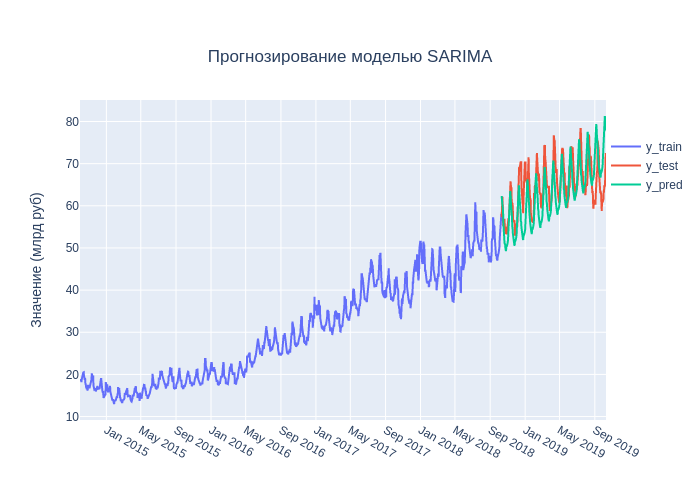

In [33]:
plotly_series(y_train, y_test, sarima_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Прогнозирование моделью SARIMA')

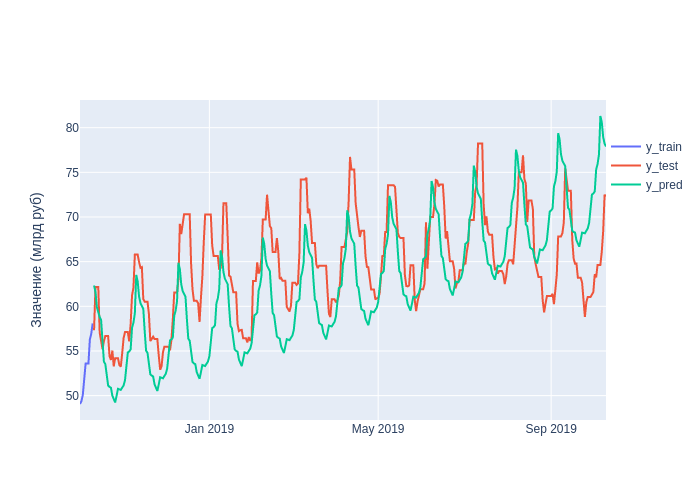

In [34]:
plotly_series(y_train['2018-10-01':], y_test, sarima_y_pred, labels=["y_train", "y_test", "y_pred"])

Также построим 90%-ый доверительный интервал

In [35]:
sarima_y_pred_int = sarima_model.predict_interval(fh)

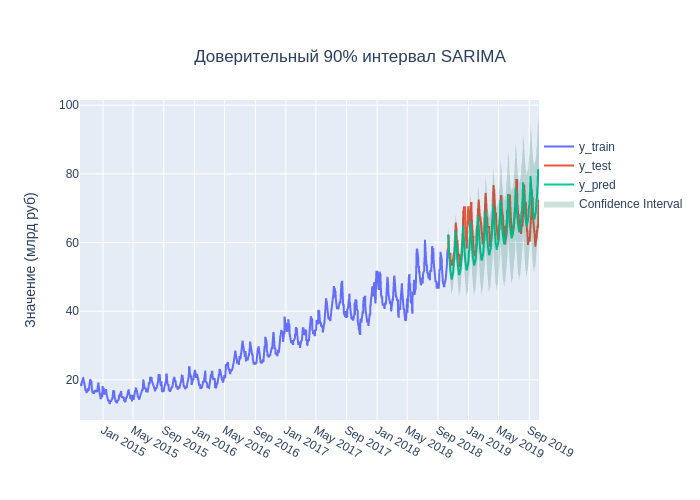

In [36]:
plotly_series(y_train, y_test, sarima_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Доверительный 90% интервал SARIMA', ci=sarima_y_pred_int)

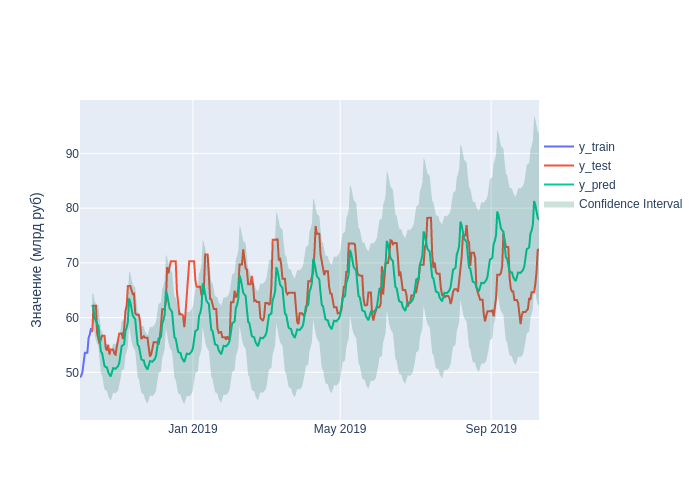

In [37]:
plotly_series(y_train['2018-10-01':], y_test, sarima_y_pred, labels=["y_train", "y_test", "y_pred"], ci=sarima_y_pred_int)

In [38]:
results["SARIMA"] = {"sMAPE": sMAPE(y_test, sarima_y_pred), "break": max_breakdown(y_test, sarima_y_pred)}
print(f"SARIMA sMAPE - {results['SARIMA']['sMAPE']}")
print(f"SARIMA breakdown - {results['SARIMA']['break']}")

SARIMA sMAPE - 7.33502
SARIMA breakdown - 0


Пробития нет, однако ошибка пока что высока. Требуется рассмотреть еще одну модель для улучшения прогноза.

### Prophet

Прогноз $y(t)$ состоит из нескольких компонент:

$$y(t) = g(t) + s(t) + h(t) + ɛ_t$$

*  $g(t)$ $-$ тренд
*  $s(t)$ $-$ сезонная компонента
*  $h(t)$ $-$ выходные или праздники
*  $\varepsilon_t$ $-$ остатки (та информация, которая не учтена моделью)

In [39]:
prophet_model = Prophet(
    freq='D',
    add_seasonality = {'name':'monthly', 'period':30.5, 'fourier_order':3, 'prior_scale': 0.1}, # о сезонности
    add_country_holidays = {'country_name':'RU'}, # информация о праздничных днях
    growth='linear', # тренд
    changepoint_prior_scale=0.7, # более высокие значения позволяют иметь больше точек излома
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='multiplicative'
)
prophet_model.fit(y_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8pik5fo/jqixkvxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8pik5fo/jl_io9ft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9530', 'data', 'file=/tmp/tmpn8pik5fo/jqixkvxp.json', 'init=/tmp/tmpn8pik5fo/jl_io9ft.json', 'output', 'file=/tmp/tmpn8pik5fo/prophet_modelh6zkixpx/prophet_model-20240204223959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'RU'},
        add_seasonality={'fourier_order': 3, 'name': 'monthly', 'period': 30.5,
                         'prior_scale': 0.1},
        changepoint_prior_scale=0.7, freq='D',
        seasonality_mode='multiplicative')

In [40]:
prophet_y_pred = prophet_model.predict(fh)

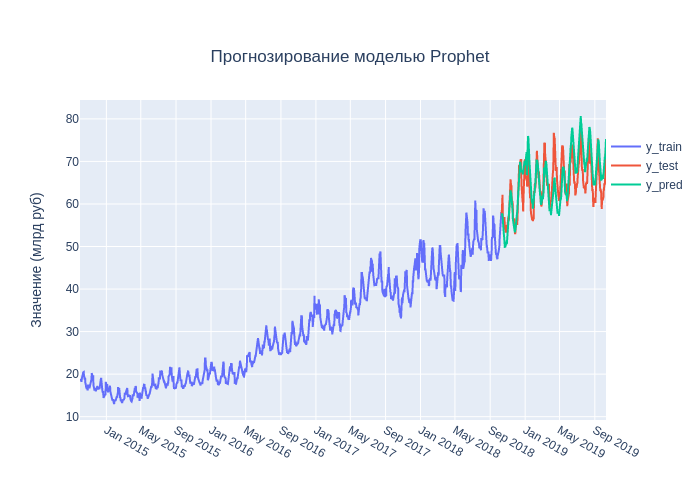

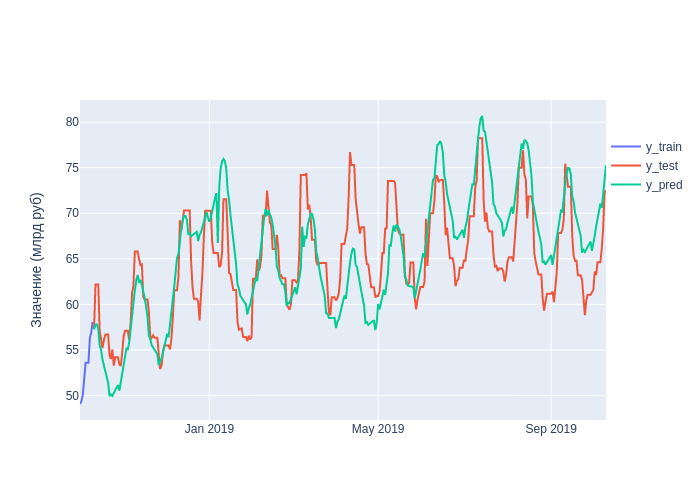

In [41]:
plotly_series(y_train, y_test, prophet_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Прогнозирование моделью Prophet')
plotly_series(y_train['2018-10-01':], y_test, prophet_y_pred, labels=["y_train", "y_test", "y_pred"])

In [42]:
prophet_y_pred_ci = prophet_model.predict_interval(fh)

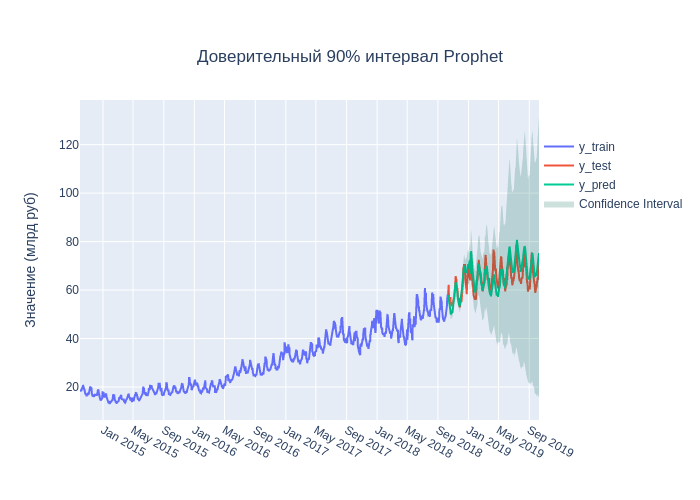

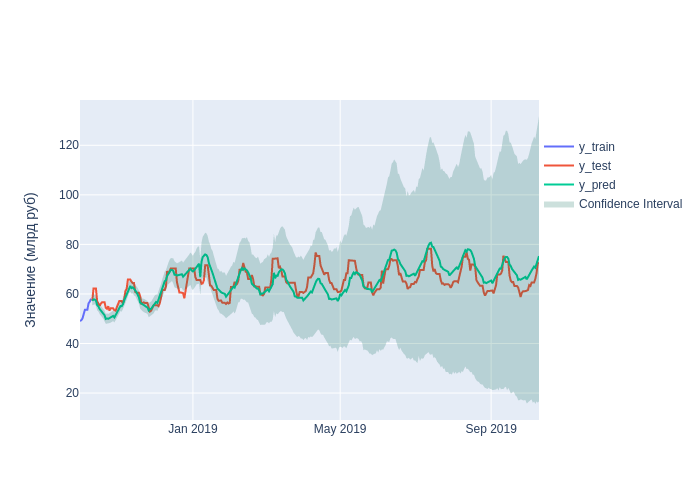

In [43]:
plotly_series(y_train, y_test, prophet_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Доверительный 90% интервал Prophet', ci=prophet_y_pred_ci)
plotly_series(y_train['2018-10-01':], y_test, prophet_y_pred, labels=["y_train", "y_test", "y_pred"], ci=prophet_y_pred_ci)

In [44]:
results["Prophet"] = {"sMAPE": sMAPE(y_test, prophet_y_pred), "break": max_breakdown(y_test, prophet_y_pred)}
print(f"Prophet sMAPE - {results['Prophet']['sMAPE']}")
print(f"Prophet breakdown - {results['Prophet']['break']}")

Prophet sMAPE - 5.30882
Prophet breakdown - 0


Очень хороший прогноз по sMAPE. Также нет пробития.

**На этом этапе:**
- Определили функции для расчета метрик
- Разделили выборку на обучающую и тестовую
- Построили простую `sNAIVE`-модель в качестве baseline
- Построили модель `SARIMA`
- Построили модель `Prophet`


## Модели регрессии

Добавим к нашим данным признаки для обучения классических регрессионных моделей.

Сначала добавим признаки по дате.

In [45]:
country_holidays = holidays.CountryHoliday('RUS')


def is_spring(month):
    return int(3 <= month <= 5)

def is_summer(month):
    return int(6 <= month <= 8)

def is_autumn(month):
    return int(9 <= month <= 11)

def is_winter(month):
    return int(month in [12, 1, 2])

In [46]:
data = data['2014-10-01':]

In [47]:
data['VALUE'] = data['VALUE'] / 10**9
data['month'] = data.index.month
data['DoM'] = data.index.day
data['DoY'] = data.index.day_of_year
data['DoW'] = data.index.weekday
data['week_number'] = data.index.week
data['is_winter'] = data.index.month.map(is_winter)
data['is_spring'] = data.index.month.map(is_spring)
data['is_summer'] = data.index.month.map(is_summer)
data['is_autumn'] = data.index.month.map(is_autumn)
data['is_weekend'] = data.index.weekday.isin([5,6])*1
data['is_holiday'] = data.index.to_series().apply(lambda x: int(x in country_holidays))

In [48]:
data.head(10)

,VALUE,month,DoM,DoY,DoW,week_number,is_winter,is_spring,is_summer,is_autumn,is_weekend,is_holiday
REPORTDATE,,,,,,,,,,,,
2014-10-01,18.816338,10,1,274,2,40,0,0,0,1,0,0
2014-10-02,18.523101,10,2,275,3,40,0,0,0,1,0,0
2014-10-03,18.680487,10,3,276,4,40,0,0,0,1,0,0
2014-10-04,18.680487,10,4,277,5,40,0,0,0,1,1,0
2014-10-05,18.680487,10,5,278,6,40,0,0,0,1,1,0
2014-10-06,18.167959,10,6,279,0,41,0,0,0,1,0,0
2014-10-07,18.797589,10,7,280,1,41,0,0,0,1,0,0
2014-10-08,19.111793,10,8,281,2,41,0,0,0,1,0,0
2014-10-09,19.453544,10,9,282,3,41,0,0,0,1,0,0


Мы не можем добавить признаки, полученные из значений, поскольку мы занимаемся прогнозом и не можем заглянуть в будущее.

Разделим на обчающую и тестовую выборки и приведем все к одному масштабу.

In [49]:
train, test = data[:'2018-10-11'], data['2018-10-11':]

X_train, y_train = train.reset_index().drop(['REPORTDATE', 'VALUE'], axis=1), train['VALUE']
X_test, y_test = test.reset_index().drop(['REPORTDATE', 'VALUE'], axis=1), test['VALUE']

### Линейная регрессия

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [51]:
lr_y_pred = lr.predict(X_test)
lr_y_pred = pd.Series(lr_y_pred, index=y_test.index)

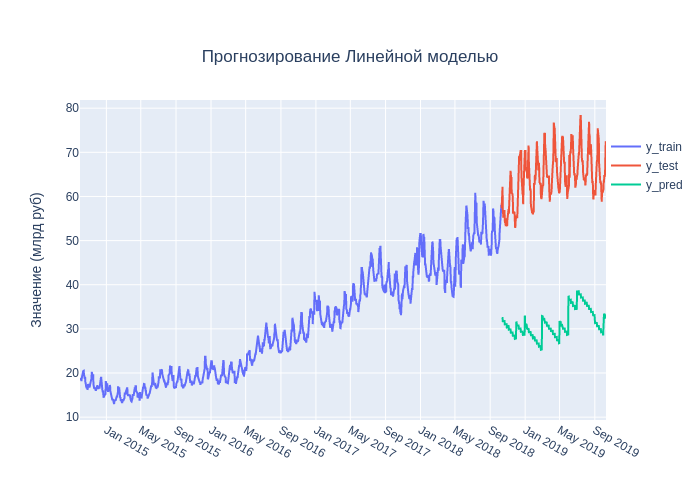

In [52]:
plotly_series(y_train, y_test, lr_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Прогнозирование Линейной моделью')

### CatBoost

In [53]:
catboost_model = CatBoostRegressor(loss_function="MAPE")
train_pool = Pool(X_train, y_train)

In [54]:
param_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations': [500, 1000],
        'l2_leaf_reg': [3, 5, 7, 9]
}
grid_search = catboost_model.grid_search(param_grid,
                                          train_pool,
                                          cv=3,
                                          verbose=True)

Выходные данные были обрезаны до нескольких последних строк (5000).
26:	learn: 0.4543418	test: 0.4581915	best: 0.4581915 (26)	total: 58.8ms	remaining: 2.12s
27:	learn: 0.4480689	test: 0.4523370	best: 0.4523370 (27)	total: 60.5ms	remaining: 2.1s
28:	learn: 0.4422054	test: 0.4466724	best: 0.4466724 (28)	total: 61.5ms	remaining: 2.06s
29:	learn: 0.4369367	test: 0.4416578	best: 0.4416578 (29)	total: 61.9ms	remaining: 2s
30:	learn: 0.4319987	test: 0.4369231	best: 0.4369231 (30)	total: 62.3ms	remaining: 1.95s
31:	learn: 0.4266578	test: 0.4321585	best: 0.4321585 (31)	total: 65.7ms	remaining: 1.99s
32:	learn: 0.4222693	test: 0.4280327	best: 0.4280327 (32)	total: 66ms	remaining: 1.93s
33:	learn: 0.4174007	test: 0.4242133	best: 0.4242133 (33)	total: 69.2ms	remaining: 1.97s
34:	learn: 0.4133465	test: 0.4205372	best: 0.4205372 (34)	total: 70.5ms	remaining: 1.94s
35:	learn: 0.4095238	test: 0.4170964	best: 0.4170964 (35)	total: 71.3ms	remaining: 1.91s
36:	learn: 0.4059657	test: 0.4140002	best: 0.414

In [57]:
best_params = grid_search['params']
best_params

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.1}

In [58]:
catboost_model = CatBoostRegressor(**best_params)
catboost_model.fit(train_pool)

0:	learn: 12.2108960	total: 507us	remaining: 507ms
1:	learn: 12.1652765	total: 985us	remaining: 492ms
2:	learn: 12.1099637	total: 1.34ms	remaining: 444ms
3:	learn: 12.0726529	total: 1.68ms	remaining: 418ms
4:	learn: 12.0347106	total: 2.02ms	remaining: 403ms
5:	learn: 11.9964046	total: 2.37ms	remaining: 393ms
6:	learn: 11.9730840	total: 2.71ms	remaining: 385ms
7:	learn: 11.9599719	total: 3.07ms	remaining: 381ms
8:	learn: 11.9323530	total: 3.43ms	remaining: 378ms
9:	learn: 11.9149602	total: 3.78ms	remaining: 374ms
10:	learn: 11.8950455	total: 4.12ms	remaining: 370ms
11:	learn: 11.8805909	total: 4.46ms	remaining: 367ms
12:	learn: 11.8647304	total: 4.8ms	remaining: 364ms
13:	learn: 11.8580872	total: 5.14ms	remaining: 362ms
14:	learn: 11.8438810	total: 5.49ms	remaining: 361ms
15:	learn: 11.8348812	total: 5.82ms	remaining: 358ms
16:	learn: 11.8259559	total: 6.15ms	remaining: 356ms
17:	learn: 11.8155103	total: 6.47ms	remaining: 353ms
18:	learn: 11.8082056	total: 6.78ms	remaining: 350ms
19:	le

In [59]:
cb_y_pred = catboost_model.predict(X_test)
cb_y_pred = pd.Series(cb_y_pred, index=y_test.index)

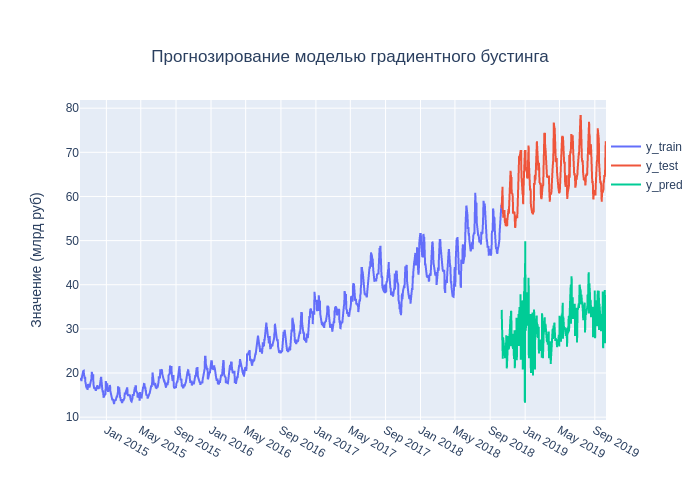

In [60]:
plotly_series(y_train, y_test, cb_y_pred, labels=["y_train", "y_test", "y_pred"],
              title='Прогнозирование моделью градиентного бустинга')

**На этом этапе:**
- Построили признаки из даты для обучения классических моделей
- Обучили линейную регрессию на преобразованном датасете
- Подобрали оптимальные параметры для `CatBoost` градиентного бустинга и обучили
- Поняли, что такие варианты несколько хуже чем модели временных рядов справляются с задачей

## Оценка стабильной части

In [61]:
pd.DataFrame(results)

,Naive,SARIMA,Prophet
sMAPE,6.92742,7.33502,5.30882
break,2.34531,0.00000,0.00000


Построим функцию `model_forecast` для оценки стабильной части наилучшей моделью `Prophet`

In [62]:
y_train, y_test = temporal_train_test_split(y, test_size=365)

In [ ]:
def model_forecast(date_from, period, history=y_train, y_test=y_test):
    model = Prophet(
        freq='D',
        add_seasonality = {'name':'monthly', 'period':30.5, 'fourier_order':3, 'prior_scale': 0.1},
        add_country_holidays = {'country_name':'RU'},
        growth='linear', changepoint_prior_scale=0.7, yearly_seasonality='auto',
        weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='multiplicative'
    )
    model.fit(history)

    date_to = (pd.to_datetime(date_from) + pd.DateOffset(months=int(period[:-1]))).strftime('%Y-%m-%d')
    y_pred = model.predict(pd.date_range(start=date_from, end=date_to, freq='D'))
    print('-----')
    print(f'From : {date_from}')
    print(f'Period: {period}')
    print(f'Stable part: {round(y_pred.min(), 5) * 10**9}')
    print(f'Max breakdown: {max_breakdown(y_test[date_from:date_to], y_pred) * 10**9}')
    print(f'sMAPE: {sMAPE(y_test[date_from:date_to], y_pred)}')

In [ ]:
model_forecast('2018-10-11', '1M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/816okr4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/wfjo7zpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96152', 'data', 'file=/tmp/tmp4zk3q8_j/816okr4g.json', 'init=/tmp/tmp4zk3q8_j/wfjo7zpl.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_model9rrkz9af/prophet_model-20240204214205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 1M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 5.25192


In [ ]:
model_forecast('2018-10-11', '2M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/q1e0xheo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/b5ciee03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60018', 'data', 'file=/tmp/tmp4zk3q8_j/q1e0xheo.json', 'init=/tmp/tmp4zk3q8_j/b5ciee03.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_modelwhkxtrma/prophet_model-20240204214208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 2M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 3.87564


In [ ]:
model_forecast('2018-10-11', '3M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/z2641kds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/q9k4bifb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79415', 'data', 'file=/tmp/tmp4zk3q8_j/z2641kds.json', 'init=/tmp/tmp4zk3q8_j/q9k4bifb.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_model2azjxjkt/prophet_model-20240204214212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 3M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.64003


In [ ]:
model_forecast('2018-10-11', '4M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsf1a2_is/sz5czc0o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsf1a2_is/sxzrex_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88797', 'data', 'file=/tmp/tmpsf1a2_is/sz5czc0o.json', 'init=/tmp/tmpsf1a2_is/sxzrex_r.json', 'output', 'file=/tmp/tmpsf1a2_is/prophet_modelc9mkck5h/prophet_model-20240130231512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 4M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.73779


In [ ]:
model_forecast('2018-10-11', '5M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/_gay5sy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/7wjb_5cn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31466', 'data', 'file=/tmp/tmp4zk3q8_j/_gay5sy0.json', 'init=/tmp/tmp4zk3q8_j/7wjb_5cn.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_modelxj6avlld/prophet_model-20240204214214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 5M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.49397


In [ ]:
model_forecast('2018-10-11', '6M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/e8lgifzr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/f03obt0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30461', 'data', 'file=/tmp/tmp4zk3q8_j/e8lgifzr.json', 'init=/tmp/tmp4zk3q8_j/f03obt0e.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_modelc6dje1pk/prophet_model-20240204214225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 6M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.61173


In [ ]:
model_forecast('2018-10-11', '7M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/il1_4f5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/1n0m9vsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71558', 'data', 'file=/tmp/tmp4zk3q8_j/il1_4f5b.json', 'init=/tmp/tmp4zk3q8_j/1n0m9vsp.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_model5qw5kg_t/prophet_model-20240204214232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 7M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 5.23688


In [ ]:
model_forecast('2018-10-11', '8M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/yc107jvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/bmi884tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50865', 'data', 'file=/tmp/tmp4zk3q8_j/yc107jvw.json', 'init=/tmp/tmp4zk3q8_j/bmi884tf.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_model60hkgq9a/prophet_model-20240204214235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 8M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.94862


In [ ]:
model_forecast('2018-10-11', '9M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/q4eib_h7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/7_76iice.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6445', 'data', 'file=/tmp/tmp4zk3q8_j/q4eib_h7.json', 'init=/tmp/tmp4zk3q8_j/7_76iice.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_modely2lrh5db/prophet_model-20240204214240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 9M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 4.97981


In [ ]:
model_forecast('2018-10-11', '10M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/4glnzsjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/hpitf850.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83022', 'data', 'file=/tmp/tmp4zk3q8_j/4glnzsjg.json', 'init=/tmp/tmp4zk3q8_j/hpitf850.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_model2gdf19_7/prophet_model-20240204214244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 10M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 5.19204


In [ ]:
model_forecast('2018-10-11', '11M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/1eacu062.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zk3q8_j/z8_2ne23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69737', 'data', 'file=/tmp/tmp4zk3q8_j/1eacu062.json', 'init=/tmp/tmp4zk3q8_j/z8_2ne23.json', 'output', 'file=/tmp/tmp4zk3q8_j/prophet_modelp4ee7jxa/prophet_model-20240204214252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 11M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 5.1961


In [ ]:
model_forecast('2018-10-11', '12M')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsf1a2_is/lyxno1bk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsf1a2_is/ljol4v_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40506', 'data', 'file=/tmp/tmpsf1a2_is/lyxno1bk.json', 'init=/tmp/tmpsf1a2_is/ljol4v_7.json', 'output', 'file=/tmp/tmpsf1a2_is/prophet_model9wdlydeg/prophet_model-20240130231731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----
From : 2018-10-11
Period: 12M
Stable part: 49926740000.0
Max breakdown: 0
sMAPE: 5.30882


Видим, что стабильная часть для любого периода неизменна и принимает минимальное возможное значение. При этом у нас отсутсвует пробитие, чего мы и добивались. Вцелом это довольно неплохо.

Если нам необходимо как-то изменять наш уровень стабильной части и мы готовы терпеть небольшие издержки, связанные с пробитием, то можно адаптировать функцию поиска стабильной части.

Пусть горизонт все также 12 месяцев. Стабильную часть будем брать как среднее по минимальным за каждый месяц.

In [63]:
model = Prophet(
        freq='D',
        add_seasonality = {'name':'monthly', 'period':30.5, 'fourier_order':3, 'prior_scale': 0.1},
        add_country_holidays = {'country_name':'RU'},
        growth='linear', changepoint_prior_scale=0.7, yearly_seasonality='auto',
        weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='multiplicative'
)
model.fit(y_train)

y_pred = model.predict(y_test.index)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8pik5fo/uyjhcp9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8pik5fo/sb1a1dcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75227', 'data', 'file=/tmp/tmpn8pik5fo/uyjhcp9y.json', 'init=/tmp/tmpn8pik5fo/sb1a1dcc.json', 'output', 'file=/tmp/tmpn8pik5fo/prophet_model5h279gyl/prophet_model-20240204224352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [64]:
stable = y_pred.resample('M').min().mean()
print(f'New Stable part: { round( stable, 5) * 10**9}')

New Stable part: 60076590000.0


In [65]:
breakdown = round(stable - y_test.min(), 5)
print(f'New breakdown: {0 if breakdown < 0 else breakdown * 10**9}')

New breakdown: 7178160000.0


Посмотрим, как выглядит прогноз и стабильные части

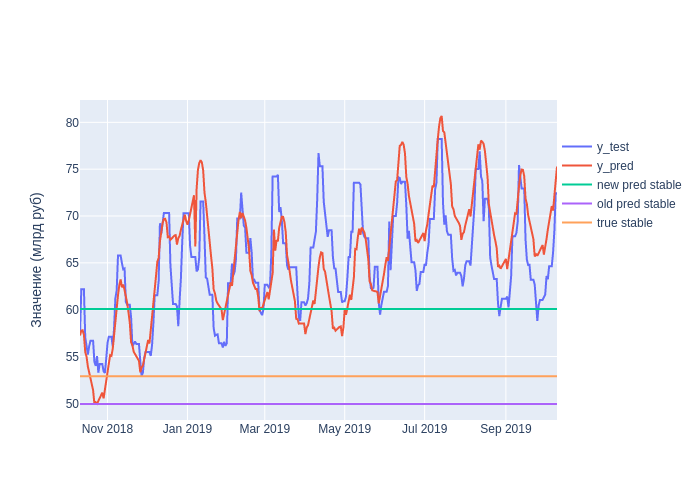

In [67]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test.index, y=y_test.values, mode='lines', name = 'y_test'))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines', name = 'y_pred'))
fig.add_trace(go.Scatter(x=[y_pred.index[0], y_pred.index[-1]], y=[stable, stable], mode='lines', name = 'new pred stable'))
fig.add_trace(go.Scatter(x=[y_pred.index[0], y_pred.index[-1]], y=[y_pred.min(), y_pred.min()], mode='lines', name = 'old pred stable'))
fig.add_trace(go.Scatter(x=[y_pred.index[0], y_pred.index[-1]], y=[y_test.min(), y_test.min()], mode='lines', name = 'true stable'))

fig.update_layout(
        yaxis_title='Значение (млрд руб)',
        title_x=0.5,
        title_y=0.9,
        xaxis=dict(dtick='M2'),
        legend= dict(orientation='v', x=1.0, y=0.9),
)

Как мне кажется, не стоит делать слишком завышенные прогнозы и брать прогнозную стабильную часть что-то около истинной (лучше чуть ниже нее).